# Домашняя работа по Neural Style Transfer

В данной работе использовались материалы:
* [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
* [Partial Style Transferring and Feature Optimization for Style
Transfer Network](https://lewkesy.github.io/data/Partial%20Style%20Transfer%20Network.pdf)
* [Localized Style Transfer](http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf)

А так же практические материалы:
* [Пример из stepik прикрепленный к заданию](https://drive.google.com/file/d/1GkM3Bt5147gkpEa97wrWxU2nLX4o4XIM/view?usp=sharing)
* [Пример, найденный на просторах интернета](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb)

Как и в лекции и на семинаре, для реализации задания используется предобученная сеть VGG-19, которая состоит из сверточных, пулинговых, а так же нескольких полносверточных слоев.

Картинки контента и стилей находятся в этом же разделе в папке NST_images

In [1]:
# Загрузим необходимые библиотеки
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
%matplotlib inline

## Загрузим VGG19 (features)

VGG19 состоит из двух частей:
* `vgg19.features`, все сверточные и пулинговые слои
* `vgg19.classifier`, выходные слои для классификации изображений в конце сети

Нам нужна только часть `features`, которую мы зарузим и заморозим веса.

In [2]:
# загружаем "features" часть сети VGG19 (часть классификации не нужна)
vgg = models.vgg19(pretrained=True).features

# замораживаем все параметры, потому что мы будем оптимизировать только целевую картинку
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
# переносим модель на gpu если он есть
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Загружаем картинки контента и стиля

Можно использовать любые картинки. Указанная ниже функция `load_image` загрузит любой тип и размер картинки, а на выходе даст нормализованный тензор.

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # добавляем размерность для батча
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Загружаем картинки указываю путь

In [67]:
# картинка контента:
content = load_image('/content/content2.jpeg').to(device)
# загружаем картинки стилей (и маски) и сразу меняем их размер в соответствии с контентом
style = load_image('/content/style3.jpg', shape=content.shape[-2:]).to(device)
style2 = load_image('/content/style4.jpg', shape=content.shape[-2:]).to(device)
# l_mask - назвал чтоб не путаться потом в левой/правой масках. r_mask будет сделана далее отражением
l_mask = load_image('/content/l_mask.jpg', shape=content.shape[-2:]).to(device)
#r_mask = load_image('/content/r_mask.jpg', shape=content.shape[-2:]).to(device)

In [50]:
# дополнительная функция для обратной нормализации картинки
# и конвертирования из тензора в numpy массив
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Text(0.5, 1.0, 'Style 2 image')

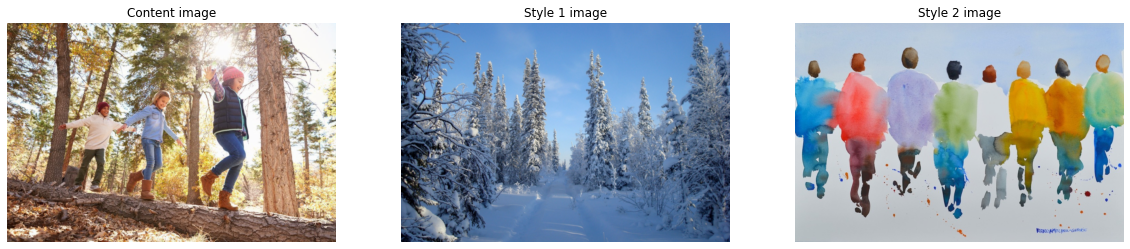

In [65]:
# посмотрим на картинки
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax1.set_title('Content image')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax2.set_title('Style 1 image')
ax3.imshow(im_convert(style2))
ax3.axis('off')
ax3.set_title('Style 2 image')

Text(0.5, 1.0, 'Mask image')

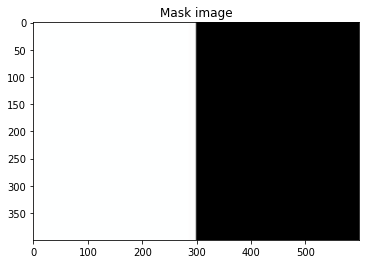

In [68]:
# посмотрим на маску
plt.imshow(im_convert(l_mask));
plt.title('Mask image')
#plt.axis('off') # показал оси чтоб было видно границы картинки

## Content and Style Features

Функция, c помощью которой будем получать фичи слоев для контента и стилей которые нужны будут в дальнейшем для отрисовки результата.

In [9]:
def get_features(image, model, layers=None):
    ## Необходимые нам слои для работы с контентом и стилями
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## контент будет только здесь
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Матрица Грам

In [10]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

## Собираем все вместе

Все функции для извлечения необходимых фич исходных картинок и подсчета матрицы Грам для каждого сверточного слоя написаны. Теперь будем все это запускать и считать для каждого слоя.

In [55]:
# создаем маску из имеющейся преобразуя в единицы и нули
l_mask = torch.clamp(l_mask, min=0, max=1)
# создаем зеркальную маску для работы с другой частью картинки
r_mask = torch.abs(1 - l_mask)

# получаем все параметры для контента и стилей один раз перед обучением
content_features = get_features(content * l_mask, vgg)
content_features2 = get_features(content * r_mask, vgg)

style_features = get_features(style, vgg)
style_features2 = get_features(style2, vgg)

# считаем матрицы Грам для каждого слоя наших стилей
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
style_grams2 = {layer: gram_matrix(style_features2[layer]) for layer in style_features2}

# создаем наш input который будет меняться в соответствии со стилями
# неплохо для этого просто сделать копию из контента
# и затем пошагово применять стиль
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Индивидуальные веса для слоев стилей

Ниже реализована опция для указания весов персонально по слоям для стилей. Значения можно использовать от 0 до 1. Первые слои (`conv1_1` и `conv2_1`) будут давать более крупные артефакты стиля чем следующие. Это из-за разных размеров сверток. Таким образом можно настраивать влияние стиля на контент.

#### Content and Style Weight

Далее обозначены alpha (`content_weight`) и a beta (`style_weight`) веса. Они влияют на финальную "стилизацию" контента. Соответственно вес контента оставляем равным 1, а вес стиля указываем по желанию.

In [54]:
# веса для каждого слоя
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Рисуем новую картинку (target или в других источниках input) и считаем потери

В цикле будем считать Content losses, Style losses и обновлять целевую картинку.

#### Content Loss

Сontent loss считается как среднеквадратичная ошибка между целевой картинкой и параметрами контента в слое `conv4_2` по следующей формуле: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

Style loss считается тем же способом, только по каждому слою, который указан в словаре выше: `style_weights`. 
> Считаем матрицу грам для целевой картинки и картинки стиля и сравниваем их для подсчета потерь в каждом слое `layer_style_loss`. 
> Затм нормализуем эти потери на размер слоя.

#### Total Loss

В конце считаем total loss путем сложения предыдущих потерь с учетом коэффициентов alpha и beta определенных выше.

Step:  400  Total loss:  53447824.0


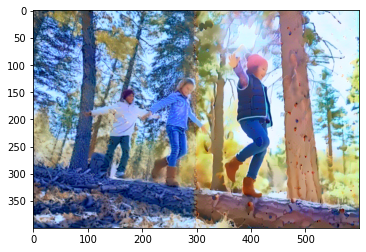

Step:  800  Total loss:  15117374.0


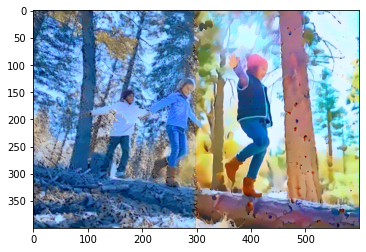

Step:  1200  Total loss:  10964430.0


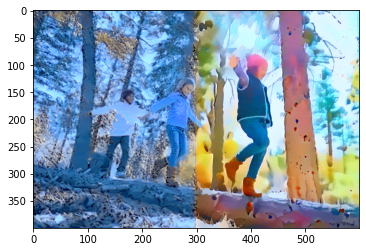

Step:  1600  Total loss:  8905998.0


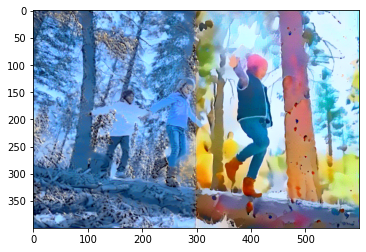

Step:  2000  Total loss:  7641893.0


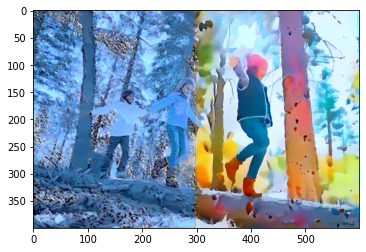

In [56]:
# для отображения целевой картинки в процессе обучения
show_every = 400

# гиперпараметры обучения
#optimizer = optim.LBFGS([target], lr=0.003)
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # можно менять количество шагов по желанию

for ii in range(1, steps+1):
    
    # получаем фичи целевой картинки (разбиты на 2 части в соответствии с маской)
    target_features = get_features(target * l_mask, vgg)
    target_features2 = get_features(target * r_mask, vgg)
    
    
    # Сontent loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    content_loss2 = torch.mean((target_features2['conv4_2'] - content_features2['conv4_2'])**2)
    
    # Style loss инициализируем с 0
    style_loss = 0
    # затем добавляем к нему потери с матрицами грам на каждом слое
    for layer in style_weights:
        # реализация для применения стилей с учетом бинарной маски
        target_feature = target_features[layer]
        target_feature2 = target_features2[layer]

        target_gram = gram_matrix(target_feature)
        target_gram2 = gram_matrix(target_feature2)

        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]
        style_gram2 = style_grams2[layer]

        # получаем потери на каждом слое
        layer_style_loss1 = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        layer_style_loss2 = style_weights[layer] * torch.mean((target_gram2 - style_gram2)**2)

        layer_style_loss = torch.mean(layer_style_loss1 + layer_style_loss2)

        style_loss += layer_style_loss / (d * h * w)
        
    # считаем total loss
    total_loss = content_weight * torch.mean(content_loss + content_loss2) + style_weight * style_loss
    
    # обновляем веса целевой картинки
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # смотрим промежуточные варианты целевой картинки во время обучения
    if  ii % show_every == 0:
        print('Step: ', ii, ' Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

Text(0.5, 1.0, 'Target image')

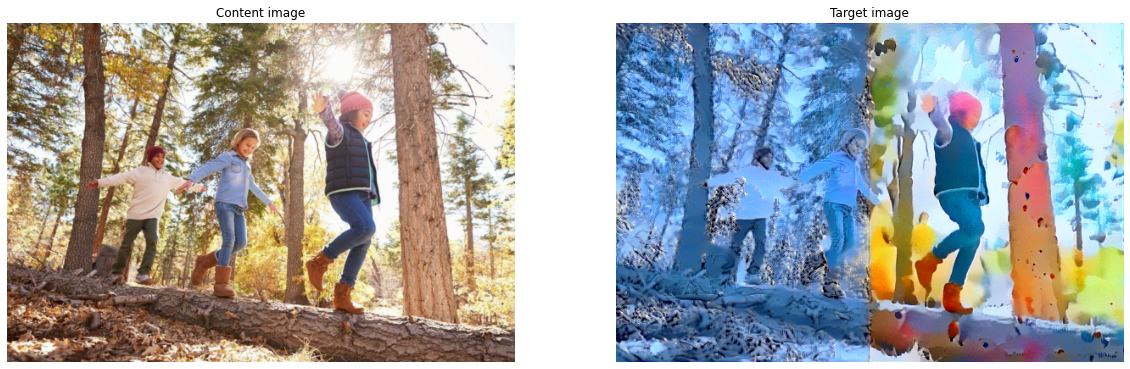

In [69]:
# смотрим финальный вариант целевой картинки и контент
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax1.set_title('Content image')
ax2.imshow(im_convert(target))
ax2.axis('off')
ax2.set_title('Target image')

### Применение двух стилей ко всей картинке

Ситуация очень похожа на предыдущую работу по применеию двух стилей к разным частям картинки с учетом маски. Отличие в том, что мы не используем маску на целевой картинке и считаем потери по стилям в среднем, а не разделяя по необходимым частям.

In [70]:
# все делаем заново, но в сокращенном варианте - без маски
content_features = get_features(content, vgg)

style_features = get_features(style, vgg)
style_features2 = get_features(style2, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
style_grams2 = {layer: gram_matrix(style_features2[layer]) for layer in style_features2}

target = content.clone().requires_grad_(True).to(device)

In [74]:
# веса alpha и beta оставил те же что и ранее
# веса для слоев создаем два словаря, чтоб можно было учесть влияние каждого стиля
style1_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.7,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

style2_weights = {'conv1_1': 0.5,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

Step:  400  Total loss:  88064304.0


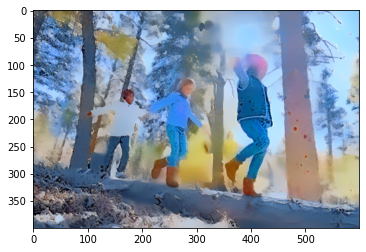

Step:  800  Total loss:  87259064.0


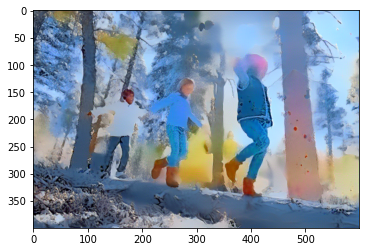

Step:  1200  Total loss:  86981192.0


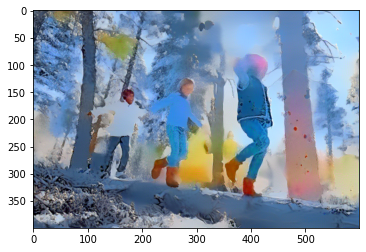

Step:  1600  Total loss:  86856632.0


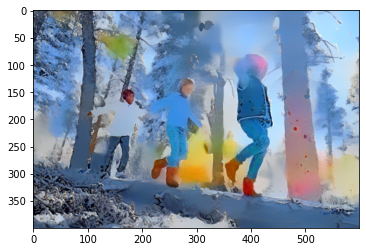

Step:  2000  Total loss:  86789600.0


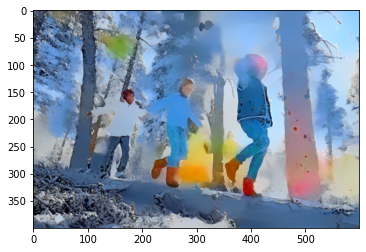

In [75]:
show_every = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0

    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        style_gram = style_grams[layer]
        style_gram2 = style_grams2[layer]
        # в отличии от предыдущего варианте потери считаем каждый раз с одной и той же целевой картинкой
        layer_style_loss1 = style1_weights[layer] * torch.mean((target_gram - style_gram)**2)
        layer_style_loss2 = style2_weights[layer] * torch.mean((target_gram - style_gram2)**2)

        layer_style_loss = torch.mean(layer_style_loss1 + layer_style_loss2)

        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Step: ', ii, ' Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

Text(0.5, 1.0, 'Target image')

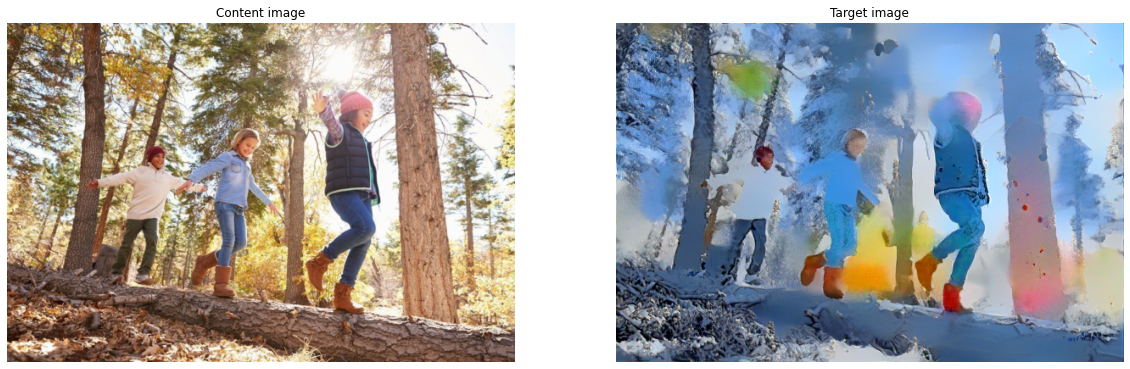

In [76]:
# смотрим финальный вариант целевой картинки и контент
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax1.set_title('Content image')
ax2.imshow(im_convert(target))
ax2.axis('off')
ax2.set_title('Target image')